# Used Car Sale Auction Prices
By Sky Reznik, John Lackey and Kevin Abatto

Import packages

In [363]:
import pandas as pd; # type: ignore
import numpy as np; # type: ignore
from sklearn.preprocessing import OneHotEncoder; # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os;
from kaggle.api.kaggle_api_extended import KaggleApi; # type: ignore

Download data using Kaggle KPI

In [364]:
# Specify the dataset and the path to save it
dataset_name = 'tunguz/used-car-auction-prices'  # Replace with your actual Kaggle dataset name
download_path = './kaggle_datasets'     # Folder to store the dataset

# Create download path if it doesn't exist
if not os.path.exists(download_path):
    os.makedirs(download_path)

# Check if file exists
dataset_file_path = os.path.join(download_path, 'car_prices.csv')   
# Check if the dataset already exists in the folder
if not os.path.exists(dataset_file_path):
    # Initialize the Kaggle API
    api = KaggleApi()
    api.authenticate()  # Authenticate using your Kaggle credentials

    # Download the dataset
    print(f"Downloading {dataset_name}...")
    api.dataset_download_files(dataset_name, path=download_path, unzip=True)

    print("Download complete.")
else:
    print("Dataset already exists, download skipped.")

# Load CSV into a pandas dataframe
shared_file_path = './kaggle_datasets/car_prices.csv'
# line 408,163 - "Model" field contains a comma (SE PZEV w/Connectivity, Navigation) - specify quotechar='"'
# This tells Pandas to treat anything inside double quotes as a single field, even if it contains commas.
#      solution provided by ChatGPT
df = pd.read_csv(shared_file_path, quotechar='"', on_bad_lines='skip')

Dataset already exists, download skipped.


/var/folders/mv/9l39xh61679g3fk2_5cyrrzh0000gn/T/ipykernel_49361/2201586472.py:30: DtypeWarning: Columns (8,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(shared_file_path, quotechar='"', on_bad_lines='skip')


In [365]:
# Load datasets
msrp = pd.read_csv('MSRP.csv')

# Standardize column names and values
msrp.rename(columns={
    'Make': 'make',
    "Model": "model",
    "Year": "year",
    "Transmission Type": "transmission"
}, inplace=True)

msrp['transmission'] = msrp['transmission'].str.lower()

# Create matching keys
df['match_key'] = (
    df['year'].astype(str).str.lower() + '_' + 
    df['make'].str.lower() + '_' + 
    df['model'].str.lower() + '_' + 
    df['transmission'].str.lower()
)

msrp['match_key'] = (
    msrp['year'].astype(str).str.lower() + '_' + 
    msrp['make'].str.lower() + '_' + 
    msrp['model'].str.lower() + '_' + 
    msrp['transmission'].str.lower()
)

# Sort by MSRP (ascending) and keep first (min) for each match_key
msrp_min_row = msrp.sort_values('MSRP').drop_duplicates('match_key', keep='first')

# Merge with original car data (keeping all car rows but adding MSRP where matched)
car_with_msrp = df.merge(
    msrp_min_row[['match_key', 'MSRP']],  # Only keep needed columns
    on='match_key',
    how='left'
)

# Drop the temporary key column
car_with_msrp = car_with_msrp.drop(columns=['match_key'])

# Save the merged DataFrame to a new CSV file
car_with_msrp.to_csv('car_prices_with_msrp.csv', index=False)

# Data Cleaning
__Done__
1) Remove any row with missing data with df.dropna()
2) One-Hot encode ['transmission'] to ['automatic_trans'] 0 /1 (double check unique vals)
3) Simplify ['body'] (collapse all 85 body types to 9 types)
4) Convert ['saledate']
5) Age of car (from ['saledate'])
6) Drop negative age cars


In [366]:
# now we can use the car_prices_with_msrp DataFrame
df = pd.read_csv('car_prices_with_msrp.csv', low_memory=False)
# Remove 'Unamed: 16' column
df.drop('Unnamed: 16', axis=1, inplace=True)

1 - Remove rows that have missing values


In [367]:
df.dropna(inplace=True)

2 - One-hot encode the 'transmission' column


In [368]:
print(df['transmission'].unique())
df['auto_transmission'] = np.where(df['transmission'].str.contains('automatic', case=False), 1, 0)

['automatic' 'manual']


3 - 'One-hot encode' the 'body' column (count 85 unique values --> reduce to 8)


In [369]:
# ['suv' 'sedan' 'convertible' 'coupe' 'wagon' 'hatchback' 'truck' 'minivan' 'van']
df['body_type'] = np.nan
df['body_type'] = np.where(df['body'].str.contains('minivan', case=False), 'minivan', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('sedan', case=False), 'sedan', df['body'])
df['body_type'] = np.where(df['body'].str.contains('wagon', case=False), 'wagon', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('coupe', case=False), 'coupe', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('koup', case=False), 'coupe', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('convertible', case=False), 'convertible', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('hatchback', case=False), 'hatchback', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains(r'\bvan\b', case=False), 'van', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('truck', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('cab', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('crew', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('suv', case=False), 'suv', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('Minivan', case=False), 'minivan', df['body_type'])

# Numerical mapping for body types
size_mapping = {
    'convertible': 0,
    'coupe': 1,
    'hatchback': 2,
    'sedan': 3,
    'wagon': 4,
    'suv': 5,
    'minivan': 6,
    'truck': 7,
    'van': 8
}

df['body_size'] = df['body_type'].map(size_mapping)

4 - Converting 'saledate' to datetime (solution provided by ChatGPT)

In [370]:
# Handle invalid or unexpected values in the 'saledate' column
# Extract just the date part (e.g., "Dec 16 2014") before conversion
df['saledate'] = pd.to_datetime(
    df['saledate'].str.extract(r'(\w{3} \d{2} \d{4})')[0], 
    format='%b %d %Y', 
    errors='coerce'
)

5 - Ensure 'saledate' is in datetime format and create a new column 'car_age'

In [371]:
df['car_age'] = np.where(
    df['saledate'].notna(),
    df['saledate'].dt.year - df['year'],
    np.nan
)

6 - Some car ages are negative, which is not possible, because a 2015 model year can exist in 2014 and subsequently be sold

In [372]:
# For rows with values less than 0, drop rows
print("Number of negative car ages: ", df[df['car_age'] < 0].shape[0])
df.drop(df[df['car_age'] < 0].index, inplace=True)
# Drop old columns 'transmission' & 'body'
df.drop(['transmission', 'body'], axis=1, inplace=True)

Number of negative car ages:  135


In [373]:
df.head()

,year,make,model,trim,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,MSRP,auto_transmission,body_type,body_size,car_age
3,2015,Volvo,S60,T5,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,2015-01-29,33300.0,1,sedan,3,0.0
12,2015,Ford,Fusion,SE,3fa6p0hdxfr145753,ca,2.0,5559.0,white,beige,enterprise vehicle exchange / tra / rental / t...,15350,12000,2015-01-13,22500.0,1,sedan,3,0.0
20,2015,Chevrolet,Impala,LTZ,2g1165s30f9103921,ca,1.9,14538.0,silver,black,enterprise vehicle exchange / tra / rental / t...,24300,7200,2015-07-07,27060.0,1,sedan,3,0.0
26,2015,Volvo,XC70,T6,yv4902nb3f1198103,ca,4.2,16506.0,brown,brown,volvo na rep/world omni,32100,32500,2015-02-26,35400.0,1,wagon,4,0.0
27,2015,Volvo,XC70,T6,yv4902nb3f1196951,ca,4.8,12725.0,beige,beige,volvo na rep/world omni,32300,32500,2015-02-12,35400.0,1,wagon,4,0.0


In [374]:
df.drop(['year', 'trim', 'vin', 'color', 'interior', 'saledate', 'body_type'], axis=1, inplace=True)

# Data Vizualization
Plot 'mmr' v. 'sellingprice'

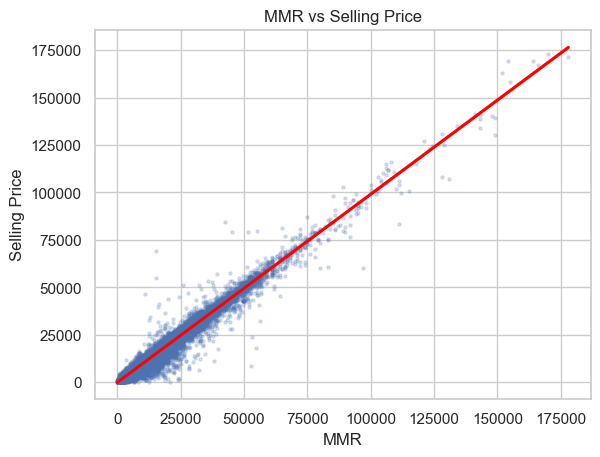

In [375]:
import matplotlib.pyplot as plt
import seaborn as sns
# ensure mmr and sellingprice are numeric
df['mmr'] = pd.to_numeric(df['mmr'], errors='coerce')
df['sellingprice'] = pd.to_numeric(df['sellingprice'], errors='coerce')
# Set the style of seaborn
sns.set(style="whitegrid")
plt.scatter(df['mmr'], df['sellingprice'], alpha=0.2, s=5) # Create a scatter plot
sns.regplot(x='mmr', y='sellingprice', data=df, scatter=False, color='red') # Linear fit line
plt.title('MMR vs Selling Price')
plt.xlabel('MMR')
plt.ylabel('Selling Price')
plt.show()

# Using features to predict selling price
List of numeric features:
1. year
2. condition
3. odometer
4. auto_transmission
5. car_age
6. MSRP

In [379]:
df_predictor = df[['condition', 'odometer', 'auto_transmission', 'car_age', 'MSRP', 'body_size']]
df_target = df['sellingprice']

In [380]:
X = df_predictor
y = df_target

Split into training and testing set

In [381]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=39)

Train the Linear Regression model

In [382]:
model = LinearRegression()

In [383]:
model.fit(X_train, Y_train)

LinearRegression()

Make predictions and evaluate the model

In [384]:
y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

r2 = r2_score(Y_test, y_pred)
print(f"R^2 (coefficient of determination): {r2}")

Mean Squared Error (MSE): 24589137.61933365
R^2 (coefficient of determination): 0.779252170913362


Plot predictions vs actual selling

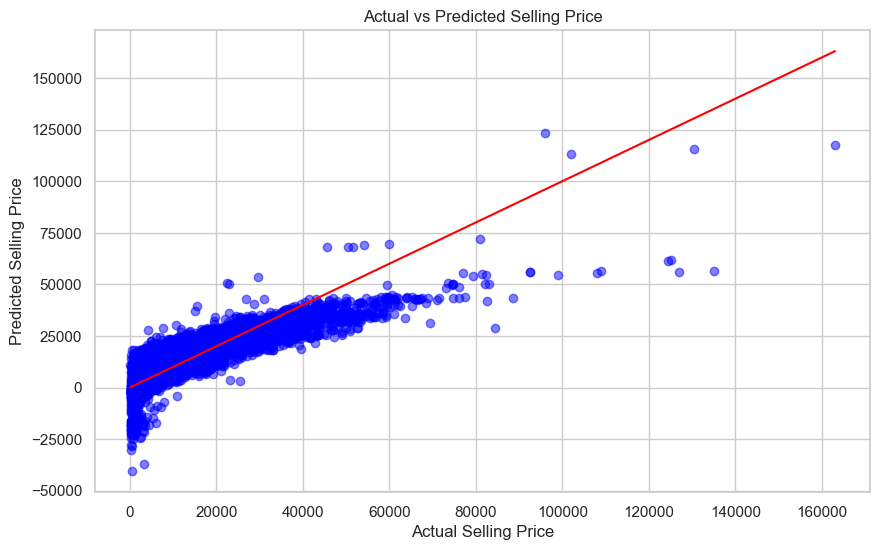

In [385]:
plt.figure(figsize=(10,6))
plt.scatter(Y_test, y_pred, alpha=0.5, color='blue') 
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linewidth=1.5) # Perfect prediction line
plt.xlabel('Actual Selling Price') 
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted Selling Price')
plt.show()

## Exploratory Data Analysis

First, let's learn more about our data now that is has been cleaned

In [ ]:
df.shape

(54346, 19)

In [ ]:
df.head(3)

,year,make,model,trim,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,MSRP,auto_transmission,body_type,body_size,car_age
3,2015,Volvo,S60,T5,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,2015-01-29,33300.0,1,sedan,3,0.0
12,2015,Ford,Fusion,SE,3fa6p0hdxfr145753,ca,2.0,5559.0,white,beige,enterprise vehicle exchange / tra / rental / t...,15350,12000,2015-01-13,22500.0,1,sedan,3,0.0
20,2015,Chevrolet,Impala,LTZ,2g1165s30f9103921,ca,1.9,14538.0,silver,black,enterprise vehicle exchange / tra / rental / t...,24300,7200,2015-07-07,27060.0,1,sedan,3,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54346 entries, 3 to 558835
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   year               54346 non-null  int64         
 1   make               54346 non-null  object        
 2   model              54346 non-null  object        
 3   trim               54346 non-null  object        
 4   vin                54346 non-null  object        
 5   state              54346 non-null  object        
 6   condition          54346 non-null  object        
 7   odometer           54346 non-null  float64       
 8   color              54346 non-null  object        
 9   interior           54346 non-null  object        
 10  seller             54346 non-null  object        
 11  mmr                54346 non-null  int64         
 12  sellingprice       54346 non-null  int64         
 13  saledate           54346 non-null  datetime64[ns]
 14  MSRP      

In [ ]:
len(df.make.unique())

39

In [ ]:
df.make.value_counts()

make
Infiniti         11997
Chevrolet         5712
Dodge             5574
Kia               4032
Chrysler          4007
Ford              3840
Lexus             2242
Pontiac           1918
Hyundai           1363
Nissan            1315
GMC               1187
Acura             1123
Mazda              912
Mercedes-Benz      807
Toyota             806
Buick              791
Cadillac           773
Lincoln            669
Volkswagen         652
Subaru             629
Honda              627
Suzuki             611
BMW                594
Volvo              574
Mitsubishi         556
Scion              296
Oldsmobile         213
Land Rover         194
Audi               121
HUMMER             105
Saab                52
Porsche             20
Bentley             15
Plymouth             9
Rolls-Royce          4
Aston Martin         2
FIAT                 2
Maserati             1
Ferrari              1
Name: count, dtype: int64

MMR is provided by the dataset... it is the "Mannheim Market Report", an estimation of a car's selling value, which is updated nightly, and trained on millions of auction transactions. For our auction data, we can assume it is a sellers goal to surpass the MMR in the auction.

Therefore, a relevant one-hot-encoding would be if the `sellingprice` > `mmr`. While it is good practice to not have redundant columns; ones which can be inferred from the data, a binary column `sold_above_mmr` would be highly useful for visualizations.

We will create it below


In [ ]:
df['sold_above_mmr'] = np.where(df['sellingprice'] > df['mmr'], 1, 0 )
df[['sellingprice', 'mmr', 'sold_above_mmr']].head(4)

,sellingprice,mmr,sold_above_mmr
3,27750,27500,1
12,12000,15350,0
20,7200,24300,0
26,32500,32100,1


Now let's visualize this data, there's alot of brands, so we'll only visualize the top 10 value counts

<Axes: xlabel='make'>

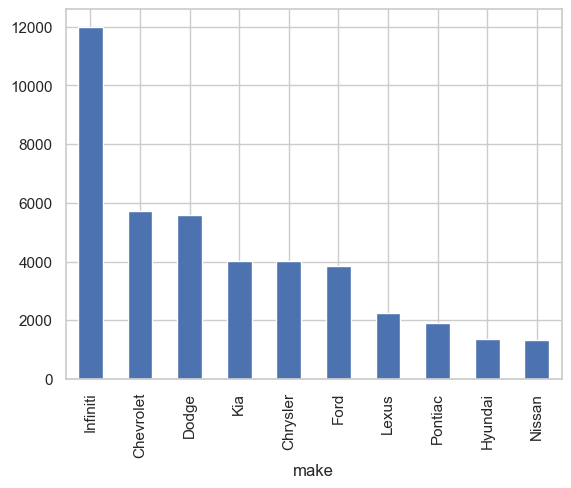

In [ ]:
top10 = df.make.value_counts().nlargest(10) # top 10
top10.plot(kind="bar")